In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal, fft
import itertools
import japanize_matplotlib

In [127]:
# CSVファイルを読み込む
file_path = "./logs/home/"

df_pressure = pd.read_csv(
    f"{file_path}Pressure.csv",
    header=0,
    names=("time", "pressure")
)

df_acc = pd.read_csv(
    f"{file_path}Accelerometer.csv",
    header=0,
    names=("time", "x", "y", "z")
)

# 加速度から重力加速度を除去
df_acc["x"] = df_acc["x"] - df_acc["x"].mean()
df_acc["y"] = df_acc["y"] - df_acc["y"].mean()
df_acc["z"] = df_acc["z"] - df_acc["z"].mean()

# 加速度のノルムを計算する
df_acc['norm'] = np.linalg.norm(df_acc[['x', 'y', 'z']], axis=1)

# 移動平均フィルターをかける
df_pressure['low'] = df_pressure['pressure'].rolling(window=240).mean()


In [128]:
# 加速度から動いているかを判定する
def check_is_moving(part_acc):
    var = part_acc['norm'].var()
    if var >= 0.1:
        return (True, 'blue', 0.2)
    else:
        return (False, 'yellow', 0.2)


# 気圧から上下に動いているかを判定する
def check_is_updown(df_pressure, t, r):
    part_press_a = df_pressure.query(f'{t} <= time < {t + r}')
    part_press_b = df_pressure.query(f'{t + r} <= time < {t + r * 2}')
    mean_a = part_press_a['low'].mean()
    mean_b = part_press_b['low'].mean()

    if abs(mean_a - mean_b) >= 0.015:
        return (True, 'blue', 0.2)
    else:
        return (False, 'yellow', 0.2)


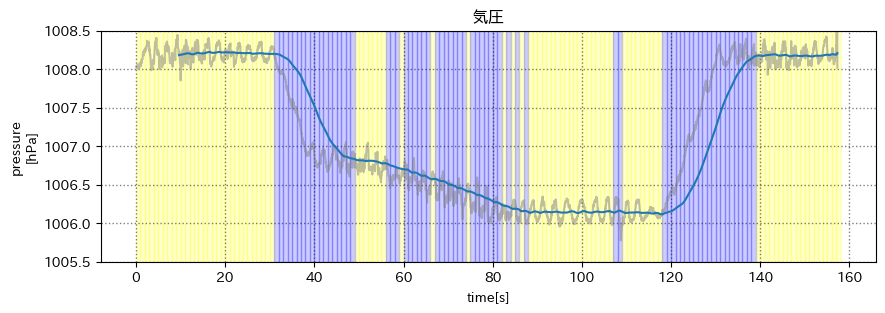

In [129]:
# 気圧
plot_pressure(df_pressure, '気圧', (0, 0), (1005.5, 1008.5))

In [130]:
# 加速度のグラフを描画する
def plot_acc(df, title, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))
  
  plt.title(title)
  plt.xlabel('time[s]')
  plt.ylabel('accelerometer\n[m/s^2]')
  plt.plot(df['time'], df['norm'])
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])

  for i in range(int(df['time'].max() + 1)):
    df_part = df.query(f'{i} <= time < {i+1}')

    is_moving, color, alpha = check_is_moving(df_part)

    plt.axvspan(i, i+1, color=color, alpha=alpha)

  plt.show()


In [131]:
# 気圧のグラフを描画する
def plot_pressure(df, title, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))
  
  plt.title(title)
  plt.xlabel('time[s]')
  plt.ylabel('pressure\n[hPa]')
  plt.plot(df['time'], df['pressure'], color='gray', alpha=0.5)
  plt.plot(df['time'], df['low'])
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])

  for i in range(int(df['time'].max() + 1)):
    df_part_a = df.query(f'{i} <= time < {i+1}')
    df_part_b = df.query(f'{i+1} <= time < {i+2}')

    is_updown, color, alpha = check_is_updown(df, i, 1)

    plt.axvspan(i, i+1, color=color, alpha=alpha)

  plt.show()


In [132]:
def correct_graph(data, x=(0, 0), y=(0, 0)):
  fig = plt.figure(figsize=(10, 3))

  plt.title('正解データ')
  plt.xlabel('time[s]')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)

  if x[0] < x[1]:
    plt.xlim(x[0], x[1])
  if y[0] < y[1]:
    plt.ylim(y[0], y[1])

  for d in data:
    if d['state'] == 'stairs':
      axvspan('stairs', d['s'], d['e'])
    elif d['state'] == 'elevator':
      axvspan('elevator', d['s'], d['e'])
    elif d['state'] == 'walk':
      axvspan('walk', d['s'], d['e'])
    elif d['state'] == 'wait':
      axvspan('wait', d['s'], d['e'])


def action_discrimination(df_acc, df_pressure, start_time=0, end_time=0):
  fig = plt.figure(figsize=(10, 3))

  plt.title('行動の判別')
  plt.xlabel('time[s]')
  plt.grid(color='k', linestyle='dotted', linewidth=1, alpha=0.5)
  plt.ylim(0, 30)
  if start_time < end_time:
    plt.xlim(start_time, end_time)

  for i in range(int(df_acc['time'].max() + 1)):
    part_acc = df_acc.query(f'{i} <= time < {i+1}')
    part_pressure_a = df_pressure.query(f'{i} <= time < {i+1}')
    part_pressure_b = df_pressure.query(f'{i+1} <= time < {i+2}')

    mean_a = part_pressure_a['low'].mean()
    mean_b = part_pressure_b['low'].mean()

    is_move, _, _ = check_is_moving(part_acc)
    is_updown = True if abs(mean_a - mean_b) >= 0.05 else False

    if is_updown and is_move:
      axvspan('stairs', i, i+1)
    elif is_updown and not is_move:
      axvspan('elevator', i, i+1)
    elif is_move:
      axvspan('walk', i, i+1)
    else:
      axvspan('wait', i, i+1)


def axvspan(state, s, e):
  if state == 'stairs':
    plt.axvspan(s, e, color="red", alpha=0.5)
  elif state == 'walk':
    plt.axvspan(s, e, color="blue", alpha=0.5)
  elif state == 'elevator':
    plt.axvspan(s, e, color="yellow", alpha=1)
  elif state == 'wait':
    plt.axvspan(s, e, color="lightgreen", alpha=0.5)


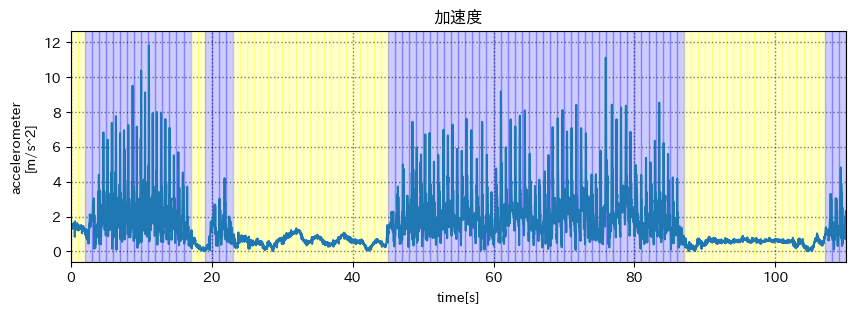

In [133]:
# 加速度
plot_acc(df_acc, '加速度', (0, 110), (0, 0))


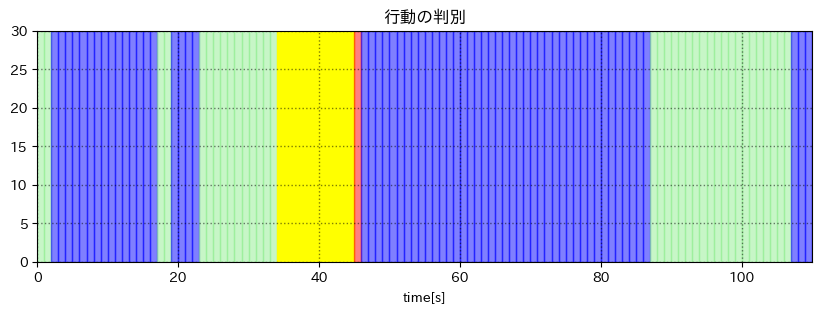

In [134]:
action_discrimination(df_acc, df_pressure, 0, 110)